In [1]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from keras import backend as K
from matplotlib import pyplot as plt
from simple_unet_model import multi_unet_model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [2]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [3]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=10 #Number of classes for segmentation


In [4]:
# dice_loss=sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
# focal_loss=sm.losses.CategoticalFocalLoss()
# total_loss=dice_loss+(1*focal_loss)

metrics=[sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5)]

In [5]:
#Capture training image info as a list
train_images = []
train_path="C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/images/train/"
for directory_path in glob.glob(train_path):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)


In [6]:
train_masks = [] 
mask_path="C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train/"
for directory_path in glob.glob(mask_path):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        print(mask_path)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train\ct14-1.png
C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train\ct14-10.png
C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train\ct14-11.png
C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train\ct14-12.png
C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train\ct14-13.png
C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train

In [267]:
print(train_images.shape)
print(train_masks.shape)

(633, 256, 256)
(633, 256, 256)


In [8]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
print(train_masks_encoded_original_shape.shape)

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3 4 5 6 7 8 9]
(633, 256, 256)


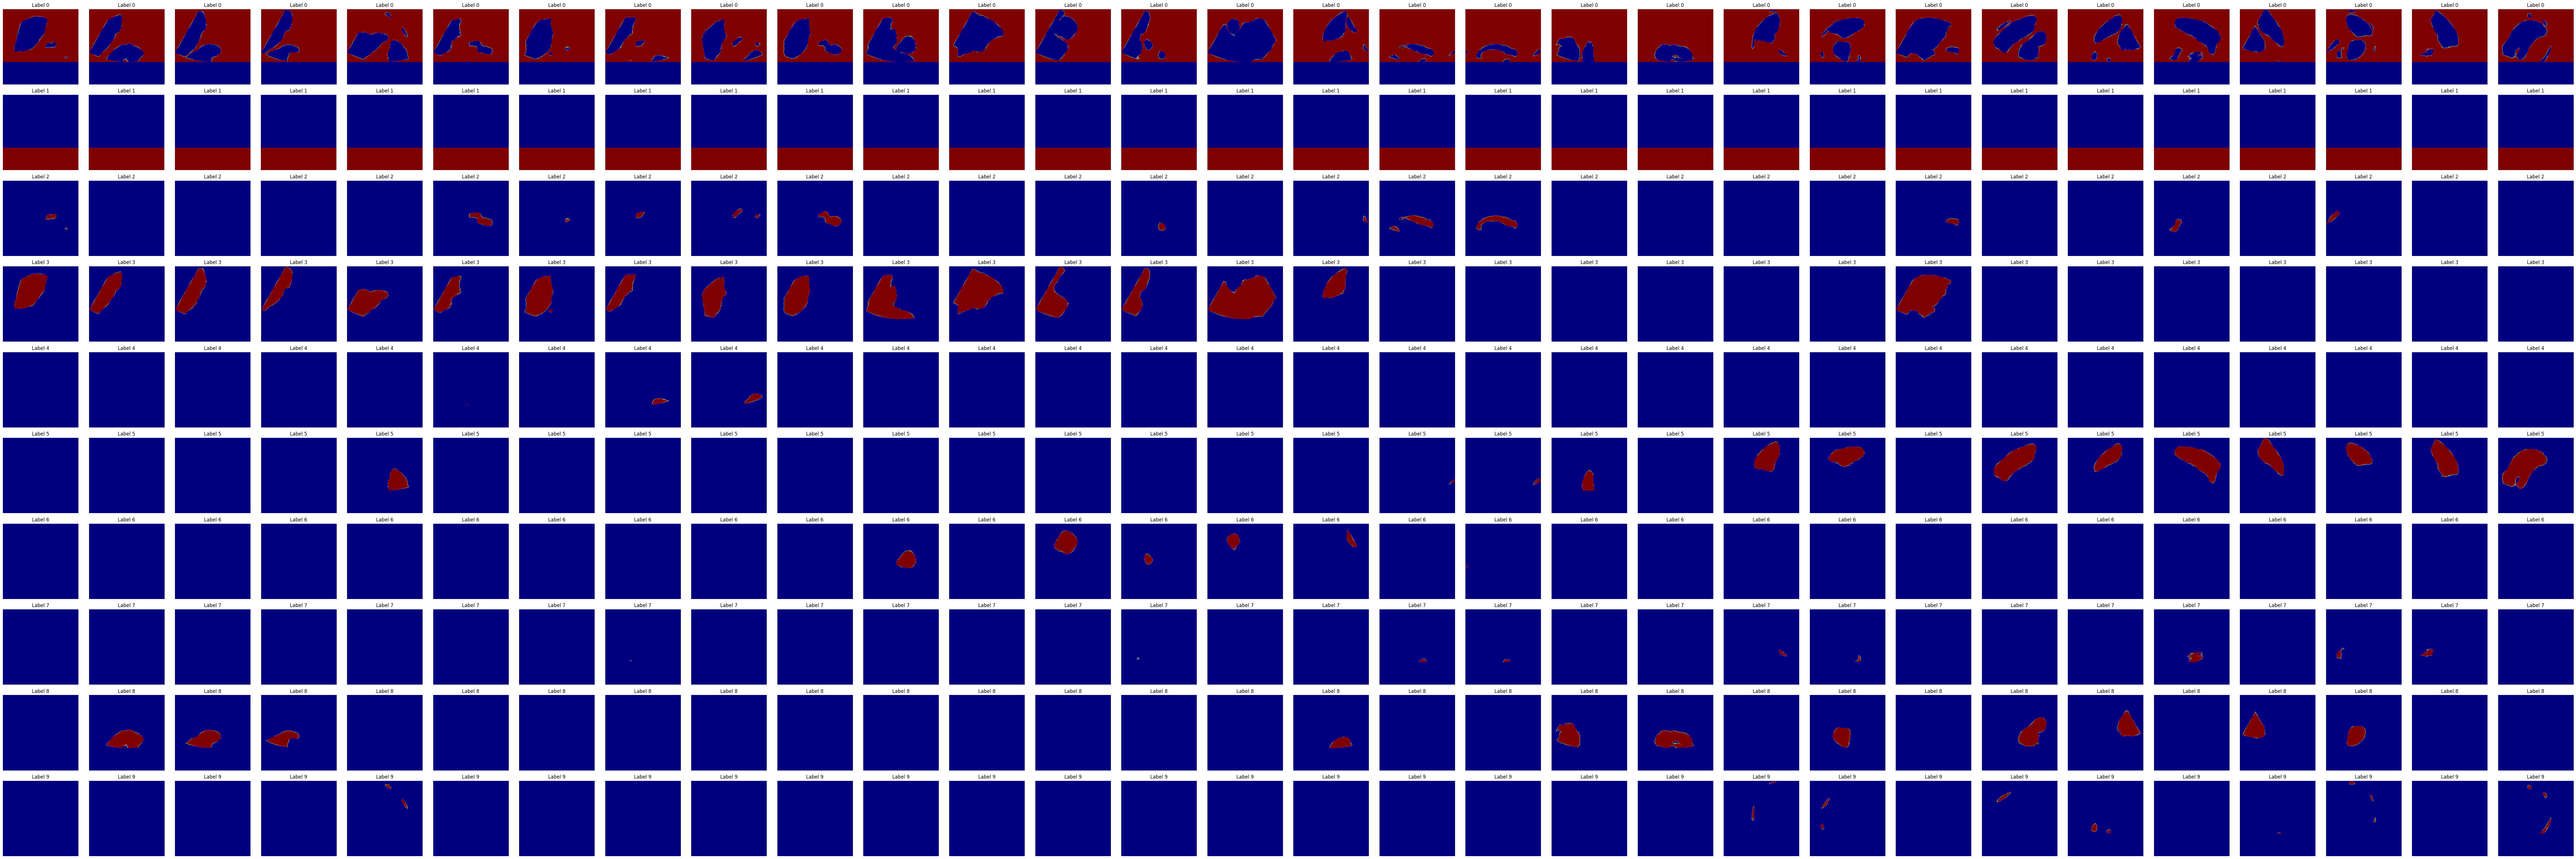

In [9]:
# Function to plot each label mask
def plot_label_masks(train_masks_encoded_original_shape, unique_labels, num_samples=5):
    fig, axs = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples * 3, len(unique_labels) * 3))
    for i, label in enumerate(unique_labels):
        for j in range(num_samples):
            if len(unique_labels) > 1:
                axs[i, j].imshow(train_masks_encoded_original_shape[j] == label, cmap='jet')
                axs[i, j].set_title(f'Label {label}')
                axs[i, j].axis('off')
            else:
                axs[j].imshow(train_masks_encoded_original_shape[j] == label, cmap='jet')
                axs[j].set_title(f'Label {label}')
                axs[j].axis('off')
    plt.tight_layout()
    plt.show()

# Get unique labels
unique_labels = np.unique(train_masks_encoded_original_shape)

# Plot label masks for the first few images
plot_label_masks(train_masks_encoded_original_shape, unique_labels, num_samples=30)

In [270]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
# X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

# print(y_train.)
#Further split training data t a smaller subset for quick testing of models
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, te/st_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8 9]


In [271]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming X_train is a NumPy array
# # Assuming y_train is a NumPy array or list

# # Get unique labels
# unique_labels = np.unique(y_train)
# list=[]
# # Plot each label's data
# print(y_train.shape)
# for label in unique_labels:
#     indices = sum(np.where(y_train == label)[0])
#     list.append(indices)
# x = np.arange(2,len(unique_labels))
# print(list)
# list.pop(0)
# list.pop(0)
# plt.figure()
# plt.bar(x, list, tick_label=unique_labels)
# plt.show()


In [272]:
print(y_train_cat.shape)
print(y_test_cat.shape)
print(train_masks_cat.shape)
print(test_masks_cat.shape)
print(train_masks_encoded_original_shape.shape)

(569, 256, 256, 10)
(64, 256, 256, 10)
(569, 256, 256, 10)
(64, 256, 256, 10)
(633, 256, 256)


In [273]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(train_masks_reshaped_encoded),
                                                 y=train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)
print(train_masks_reshaped_encoded.shape)
print("Number of classes:", len(class_weights))

Class weights are...: [1.88695257e-01 3.36842105e-01 1.08288056e+01 8.36839398e-01
 4.37565665e+01 5.60263086e+00 2.10640019e+01 2.12022324e+02
 5.68210200e+00 6.73052891e+01]
(41484288,)
Number of classes: 10


In [277]:
modified_weights = class_weights[:]

# Normalize the remaining weights
modified_weights[0]=0
modified_weights[1]=0
normalized_weights = modified_weights *10

# Print the new weights
print("Modified class weights:", normalized_weights)

Modified class weights: [   0.            0.          108.28805613    8.36839398  437.56566498
   56.02630857  210.6400195  2120.2232444    56.82101996  673.05289117]


In [278]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
print(X_train.shape)

print(n_classes)
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])
model.summary()


In [281]:
class_weight_dict = {i: weight for i, weight in enumerate(normalized_weights)}

# Print the class weight dictionary
print("Class weight dictionary:", class_weight_dict)

Class weight dictionary: {0: 0.0, 1: 0.0, 2: 108.2880561327305, 3: 8.368393979090861, 4: 437.5656649825435, 5: 56.026308574731615, 6: 210.64001949792836, 7: 2120.223244403557, 8: 56.82101996063483, 9: 673.0528911674994}


In [301]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test_cat), 
                    class_weight=class_weight_dict,
                    shuffle=False,
                    callbacks=[early_stopping])
                    

Epoch 1/10
36/36 [==============================] - 157s 4s/step - loss: -5.7751 - jacard_coef: 0.7028 - val_loss: -0.6778 - val_jacard_coef: 0.6778
Epoch 2/10
36/36 [==============================] - 135s 4s/step - loss: -5.7817 - jacard_coef: 0.7037 - val_loss: -0.6731 - val_jacard_coef: 0.6731
Epoch 3/10
36/36 [==============================] - 111s 3s/step - loss: -5.6817 - jacard_coef: 0.6905 - val_loss: -0.6676 - val_jacard_coef: 0.6676
Epoch 4/10
36/36 [==============================] - 115s 3s/step - loss: -5.7327 - jacard_coef: 0.6979 - val_loss: -0.6676 - val_jacard_coef: 0.6676
Epoch 4: early stopping


In [320]:
import joblib
# history.save('test_jacard_new.hdf5')
joblib_file = "test_jacard.hdf5"  
joblib.dump(history, joblib_file)
type(history)

keras.src.callbacks.History

In [321]:
from keras.models import load_model
model=load_model('test_jacard.hdf5')

OSError: Unable to open file (file signature not found)

{'loss': [-5.7750678062438965, -5.781694412231445, -5.681736469268799, -5.7326812744140625], 'jacard_coef': [0.7028130292892456, 0.703749418258667, 0.690453290939331, 0.69786137342453], 'val_loss': [-0.6777990460395813, -0.6731404066085815, -0.667641282081604, -0.667641282081604], 'val_jacard_coef': [0.6777990460395813, 0.6731404066085815, 0.667641282081604, 0.667641282081604]}
2/2 [==============================] - 4s 2s/step - loss: -0.6777 - jacard_coef: 0.6777
Accuracy is =  67.77267456054688 %


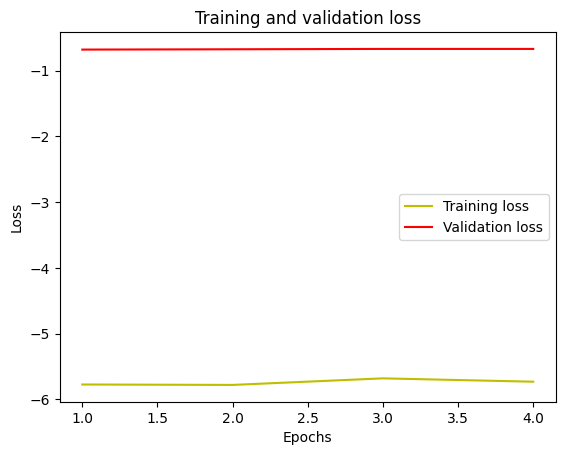

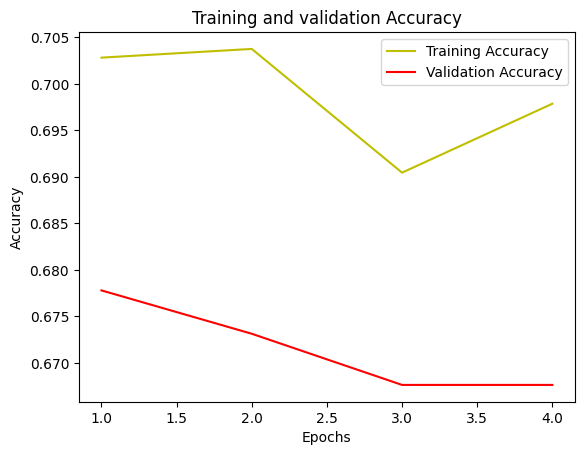

In [307]:
print(history.history)
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [318]:
# model = get_model()
# model.load_weights(history)  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
model=history
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


AttributeError: 'History' object has no attribute 'predict'

In [1]:
from keras.metrics import MeanIoU
n_classes = 10
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

NameError: name 'y_test' is not defined

In [296]:
import numpy as np

def calculate_class_iou(values, class_index):
    true_positives = values[class_index, class_index]
    false_positives = np.sum(values[class_index, :]) - true_positives
    false_negatives = np.sum(values[:, class_index]) - true_positives
    iou = true_positives / (true_positives + false_positives + false_negatives + 1e-6)  # Adding epsilon to avoid division by zero
    return iou

def calculate_all_class_iou(values, num_classes):
    class_iou_values = []
    for class_index in range(num_classes):
        class_iou = calculate_class_iou(values, class_index)
        class_iou_values.append(class_iou)
    return class_iou_values


In [297]:
class_iou_values = calculate_all_class_iou(values, num_classes=n_classes)
print("Iou values for the classes",class_iou_values)

Iou values for the classes [0.726599335732677, 0.9999999999991969, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


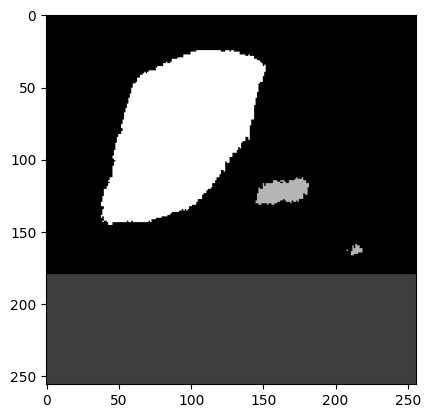

In [298]:
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 0s 91ms/step


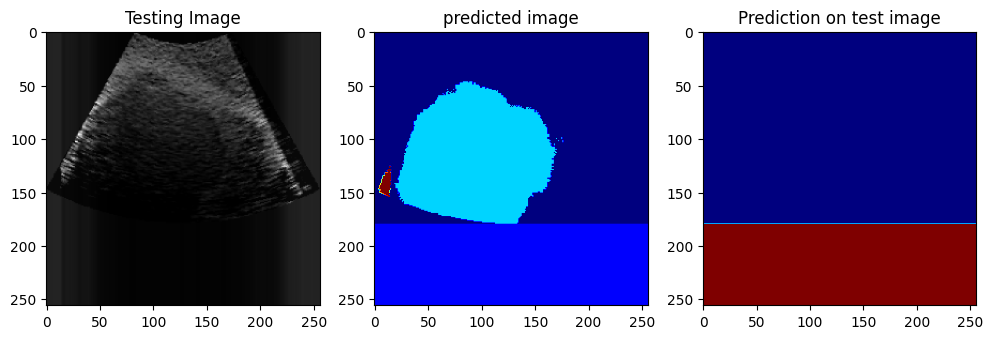

In [300]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('predicted image')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()
